# Gradient Descent  

In this notebook the following ingredients are used:
- **Data**: a few 2-dimensional points with, presumably, a linear relationship.
- **Model**: a linear function (line equation)
- **Cost (aka Loss)**: the Mean Squared Error (MSE)
- **Optimizer: Stochastic Gradient Descent (SGD)**

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import cnames
#from matplotlib import animation
from matplotlib import cm
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import clear_output, display, HTML
import ipywidgets as widgets



# The data
N=5 data points (x,y) given as two vectors X and Y.

In [2]:
data_X = np.array([-4,   -2,   1,  2.5,  3.9])
data_Y = np.array([-0.9, -0.4, 1.7, 1.5,  2.05])
print(data_X.shape)

(5,)


Text(0.5, 1.0, 'Data')

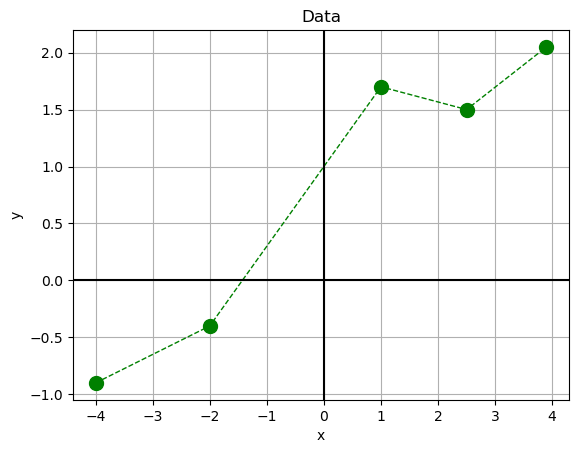

In [3]:
plt.plot(data_X, data_Y, '--og', linewidth = 1, markersize=10)
plt.grid()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')

# The model

The goal of the model is to take a value x and predict $\hat{y}$. We use the 'hat' symbol to denote an estimated (predicted) value:

$$
\hat{y} = a \cdot x + b
$$



# The Loss Function

We use the **Mean Squared Error (MSE)** (divided by 2):
$$
\begin{align}
\hat{y}_i &= a \cdot x_i + b \\  
e_i &= y_i - \hat{y}_i   \\  
E &= \frac{1}{2N}\sum_{i=1}^N e_i^2 \\  
&= \frac{1}{2N}\sum_{i=1}^N (y_i - (a \cdot x_i + b) )^2
\end{align}
$$

In [6]:
lin_model = lambda x, a, b : a*x+b

def plt_linear_model(a = 0.1, b = 0.2, X = data_X, Y = data_Y, show_error_squares=False):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes()
    
    y = lin_model(X, a, b)

    if show_error_squares:
        ax.plot(X, y, '-xb', linewidth=2)
    else:
        ax.plot(X, y, '-b', linewidth=2)
        
    ax.plot(X, Y, '--og', linewidth=1)
    ax.axhline(y=0, color='tab:gray')
    ax.axvline(x=0, color='tab:gray')
    ax.grid()
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    N = len(X)

    if show_error_squares:
        Esum = 0.
        for i in range(N):
            xi = X[i]
            yi = Y[i]
            y_hat = lin_model(xi, a, b)
            err = yi-y_hat # difference between data and model estimate
            Esum += (err**2)/2.
            if abs(err) > 0.01 :
                sq = plt.Rectangle( (xi, yi), abs(err), -err , alpha=0.2, color='r')
                ax.add_patch(sq)
                ax.plot([xi, xi], [yi, y_hat], linewidth=3, color='r')
        ax.set_title("Linear Model Params: a={:.3}, b={:.3}\nMean squared error (MSE) = {:.4f}".format(a, b, Esum/N))
    else:
        ax.set_title("Linear Model Params: a={:.3}, b={:.3}".format(a, b))
    return a, b

(0.1, 0.4)

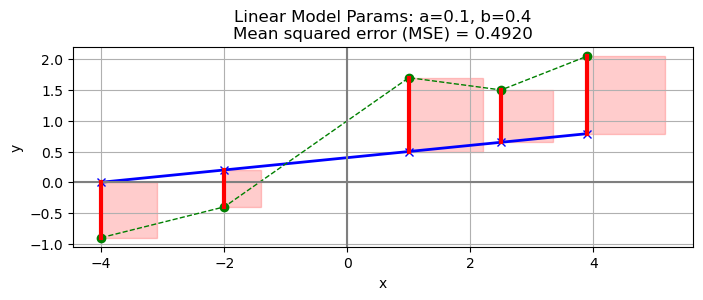

In [6]:
# example: plot the model and visualize the loss
plt_linear_model(a=0.1, b=0.4,show_error_squares=True)

# Interactive MSE minimization


In [7]:
w = interact(plt_linear_model, 
             a=widgets.FloatSlider(min=-0.5, max=0.8, step=0.02, value=0.1),
             b=widgets.FloatSlider(min=-1.0, max=1.0, step=0.02, value=0.5),
             X=fixed(data_X),
             Y=fixed(data_Y),
             show_error_squares = fixed(True))
display(w)

interactive(children=(FloatSlider(value=0.1, description='a', max=0.8, min=-0.5, step=0.02), FloatSlider(value…

<function __main__.plt_linear_model(a=0.1, b=0.2, X=array([-4. , -2. ,  1. ,  2.5,  3.9]), Y=array([-0.9 , -0.4 ,  1.7 ,  1.5 ,  2.05]), show_error_squares=False)>

In [8]:
# define the error function. It depends on the data X, Y, and on the model parameters a, b.
def sq_err(X, Y, a, b):
    N = len(X)
    Y_hat = lin_model(X, a, b)
    err = np.subtract(Y,Y_hat)
    squard_err = np.square(err)
    sum_of_squared_errors = np.sum(squard_err)
    return sum_of_squared_errors/(2.0*N)

In [9]:
# Example: 
# Evaluate the error function for the given data X, Y and 
# some point (a, b) in the parameter space
sq_err(data_X, data_Y, 0.6, 0.9)

0.26361

Calculating the MSE requires four parameters. But as the data is given (fixed), the only *variables* are the model parameters (here a and b). <br>
For simple two-parameter models, we can visualize the error at each location (a,b) of the parameter space:



In [10]:
# A helper to visualize the MSE. 

# Provide the given data_X, _Y as default values
# To plot the error function, we use a meshgrid. This is efficient, but the code is a bit harder to read.
# It contains some technicalities which are not relevant for the SGD algorithm

def plot_error(X=data_X, Y=data_Y, 
               a_min = 0.2, a_max=0.7, 
               b_min=0.3, b_max = 1., nr_mesh_points_ab=30,
               fig = None, ax = None):
    # define the region of interest. 
    A = np.linspace(a_min, a_max, nr_mesh_points_ab)
    B = np.linspace(b_min, b_max, nr_mesh_points_ab)
    aa, bb = np.meshgrid(A, B)
    
    # we wrap the (four-param) error function into a two-parameter expression and inject the Data.
    # A vectorized form of this expression can then be called directly with the meshgrid coordinates aa, bb
    vect_sq_err=np.vectorize(lambda a, b: sq_err(X, Y, a,b))
    E = vect_sq_err(aa, bb)


    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot()

    h = ax.contourf(A, B, E, levels=20, cmap=cm.coolwarm) # cmap="YlGnBu"
    fig.colorbar(h)

    # add contour lines. For better readability, transform values to get equidistant lines.
    mi = np.min(E)
    ma = np.max(E)
    r = ma-mi
    ax.contour(A, B, np.sqrt((E-mi+1e-6)/r), levels=20, colors = 'k', linewidths = 0.2) # cmap="YlGnBu"

    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_title("Error-Landscape: MSE as a function of a and b")
    ax.set_aspect('equal')

       
    return fig, ax



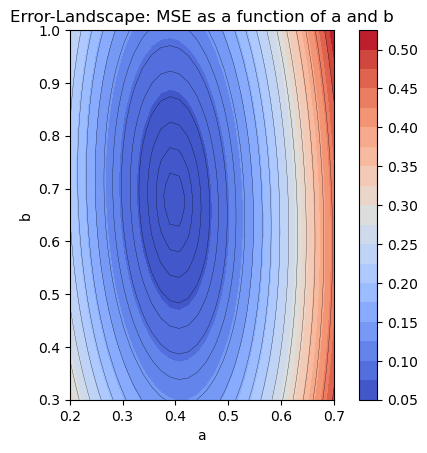

In [11]:
# For given Data, plot the error as a function of a and b.
# Note: the _ simply tells Python that we do not need the return values.
_ = plot_error(X=data_X, Y=data_Y)

We can now use this 2D plot to read out the value of the error for any model parameters (a,b).

In [13]:
sq_err(data_X, data_Y, 0.7, 1.0)

0.51949

# The Optimizer: Gradient Descent


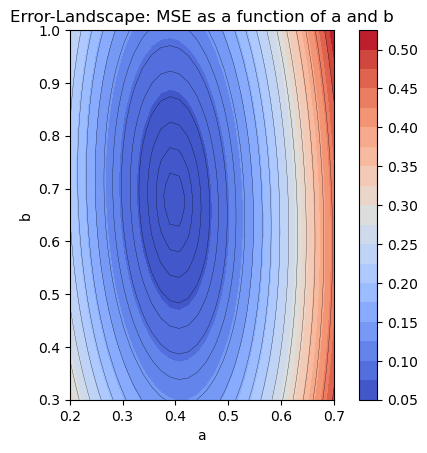

In [14]:
# plot the loss function (for given/fixed data)
_ = plot_error()

If we have access to this error plot, it is easy to estimate the best fitting parameters [a,b]: we simply pick the location [a,b] with the smallest error.

But computing this error-landscape is expensive! Even for the simple example here, the error was calculated several hundred times. Furthermore, it was necessary to predefine the search-area and a resolution for the grid.

By looking at the figure, we can identify a more efficient strategy of finding the location with the lowest error: 

**At any location [a,b] we look at the error-gradient in the neighbourhood of [a,b] and move a (small) step in the direction where the error shrinks the most.
By repeating this procedure, we will eventually arrive at the location where the error is smallest.**

This iterative procedure is, informally, the **Gradient Descent** algorithm. The method is efficient, because we do not perform a calculation (of the *error E*) at unnecessarily many location. Instead, we move along a trajectory which includes fewer points. At each point of the trajectory we evaluate the *gradient* of the error function.




In [15]:
# implement a single update step.
def update_ab(a0, da, b0, db, scaling = 1.):
    a1 = a0 + scaling * da
    b1 = b0 + scaling * db
    return a1, b1

# A helper to add a vector to the Error landscape. 
# The implementation of this function is not relevant for SGD.

def plot_error_and_grad(a0, da, b0, db, scaling = 1.,
                        X=data_X, Y=data_Y, 
                        a_min = 0.2, a_max=0.7, b_min=0.3, b_max = 1., nr_mesh_points_ab=25):

    #     fig, (axErr, axGrad) = plt.subplots(1, 2, figsize=(8, 5))
    fig = plt.figure(figsize=(7, 5))
    axErr = fig.add_subplot()
    _ = plot_error(X, Y, a_min, a_max, b_min, b_max, nr_mesh_points_ab, fig, axErr)

    a1, b1 = update_ab(a0, da, b0, db, scaling)

    axErr.plot([a0, a1], [b0, b1], '-r')        
    axErr.plot(a1, b1, 'k+', markersize=6)
    axErr.plot(a0, b0, 'ow', markersize=6)
    axErr.plot(a0, b0, 'om', markersize=4)

    err_0 = sq_err(X, Y, a0, b0)
    err_1 = sq_err(X, Y, a1, b1)
    diff = err_1 - err_0
    axErr.set_title("Err_orig= {:.4f} | Err_new= {:.4f} \nChange= {:.6f}".format(err_0, err_1, diff))

    return a1, b1, fig, axErr



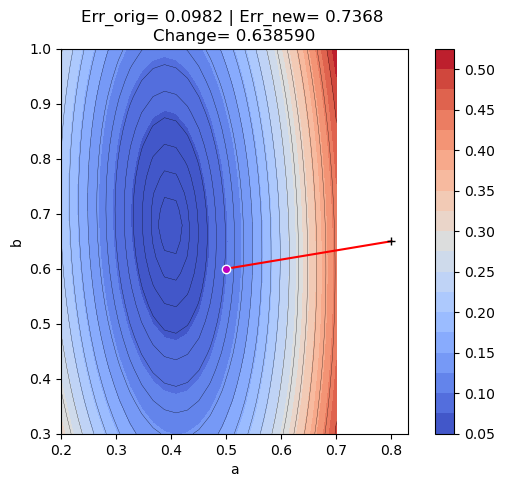

In [16]:
# this function plots the error landscape and adds a step from '+' to 'o' to the figure
_ = plot_error_and_grad(a0=0.5, da=+0.3, b0=0.6, db=0.05)

## Interactive Optimization

In [17]:
interact(plot_error_and_grad, 
    a0=fixed(0.36),
    da=widgets.FloatSlider(min=-0.1, max=0.12, step=0.005, value=0.05),
    b0 = fixed(0.78),
    db = widgets.FloatSlider(min=-0.1, max=0.1, step=0.005, value=0.0),
    scaling = fixed(0.8),
    X=fixed(data_X), Y=fixed(data_Y), 
    a_min = fixed(0.3), a_max=fixed(0.55), b_min=fixed(0.3), b_max=fixed(0.9), nr_mesh_points_ab=fixed(25)
        )



interactive(children=(FloatSlider(value=0.05, description='da', max=0.12, min=-0.1, step=0.005), FloatSlider(v…

<function __main__.plot_error_and_grad(a0, da, b0, db, scaling=1.0, X=array([-4. , -2. ,  1. ,  2.5,  3.9]), Y=array([-0.9 , -0.4 ,  1.7 ,  1.5 ,  2.05]), a_min=0.2, a_max=0.7, b_min=0.3, b_max=1.0, nr_mesh_points_ab=25)>

## Gradient Definition

We previously defined the following error function:
$$
\begin{align}
E &= \frac{1}{2N}\sum_{i=1}^N e_i^2 \\
&= \frac{1}{2N}\sum_{i=1}^N (y_i - (a \cdot x_i + b))^2\\
\end{align}
$$

In mathematical optimization and in machine learning, error functions are often called *loss*. 

**Our goal is to minimize the loss by (iteratively) changing** $a$ **and** $b$. 

For the Gradient Descent algorithm, we need the direction (in the a, b plane) of the *fastest change* (change of the loss). This direction is given by the  vector of partial derivatives:

$$
\begin{align}
    \textrm{Gradient of E} = \begin{bmatrix}
           \frac{\partial E}{\partial a} \\
           \frac{\partial E}{\partial b} \\
         \end{bmatrix}
  \end{align}
$$

In [18]:
# This is the Python implementation of the error-gradient.
# We use Lambda expressions. 
# Note the four parameters.
# We reuse the lambda expression lin_model defined at the beginning of this notebook.
# Numpy's subtract and multiply perform element-wise operations.
err_i = lambda X, Y, a, b : np.subtract(Y, lin_model(X, a, b))
dEda = lambda X, Y, a, b: (1.0 / len(X)) * np.sum(np.multiply(err_i(X, Y, a, b), -X))
dEdb = lambda X, Y, a, b: (1.0 / len(X)) * np.sum(np.multiply(err_i(X, Y, a, b), -1.))
gradE = lambda X, Y, a, b : [dEda(X, Y, a, b), dEdb(X, Y, a, b)]

We now use these expressions to evaluate the gradient at a given location and then update the parameters accordingly:

0.7890000000000003
-0.24999999999999997


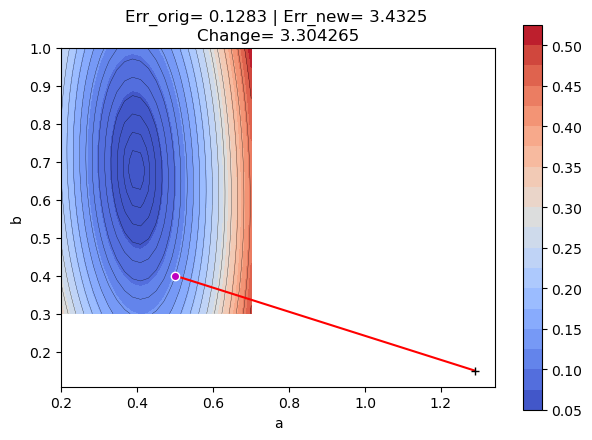

In [19]:
a = 0.5
b = 0.4
[da, db] = gradE(data_X, data_Y, a, b)
plot_error_and_grad(a, da, b, db)

print(da)
print(db)

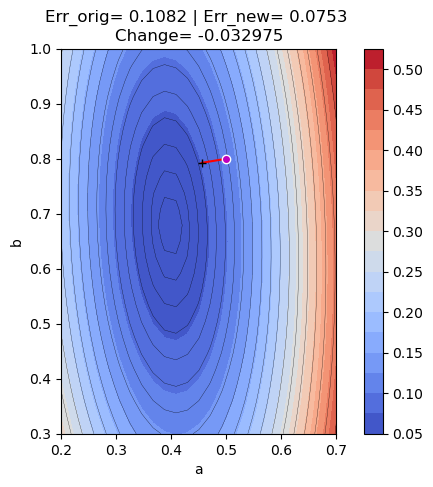

In [20]:
a = 0.5
b = 0.8
alpha = 0.05
[da, db] = gradE(data_X, data_Y, a, b)

# Note the minus sign here (since we want to step into the opposite direction):
_ = plot_error_and_grad(a, -da, b, -db, alpha)

(0.42791999999999997, 0.788)

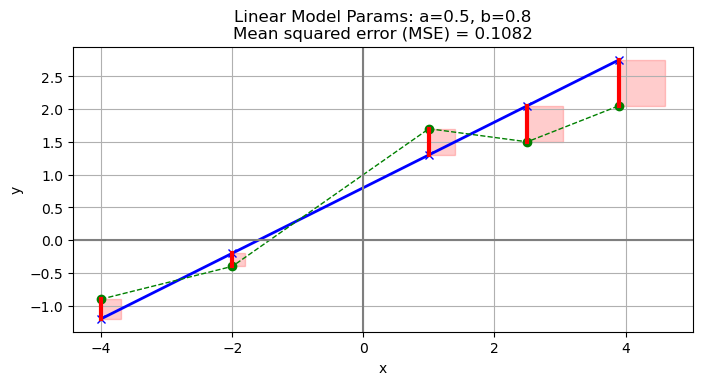

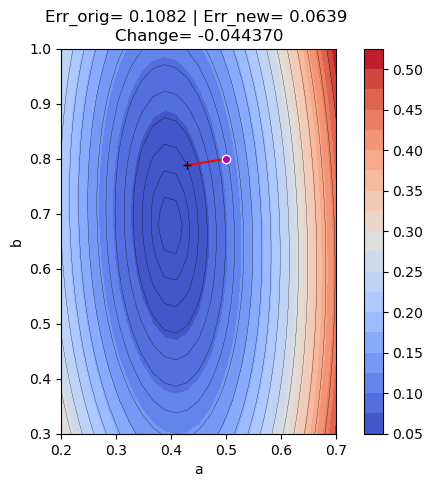

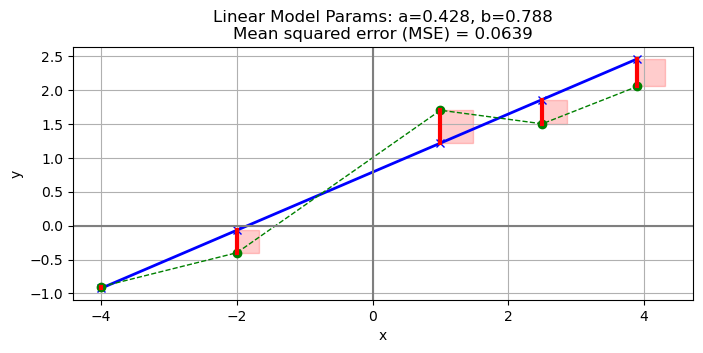

In [21]:
a0 = 0.5
b0 = 0.8
alpha = 0.08


plt_linear_model(a0, b0, data_X, data_Y, True)

[da, db] = gradE(data_X, data_Y, a0, b0)
# Note the minus sign here:
a1, b1, fig, ax = plot_error_and_grad(a0, -da, b0, -db, alpha)

plt_linear_model(a1, b1, data_X, data_Y, True)

## The Gradient Descent update rule

We can now formulate the update rule of the Gradient Descent method: <br>
At time step $t$ the parameter vector is $[a, b]_t$. At that location, the error gradient is evaluated (we use the vertical bar notation | ). The updated parameter vector  $[a, b]_{t+1}$ is obtained by making a small step in the opposite direction of the error gradient:

$$
\begin{align}
   \begin{bmatrix}
           a \\
           b \\
         \end{bmatrix}_{t+1} 
         =    \begin{bmatrix}
           a \\
           b \\
         \end{bmatrix}_{t} - \alpha 
         \begin{bmatrix}
           \frac{\partial E}{\partial a} \\
           \frac{\partial E}{\partial b} \\
         \end{bmatrix} \Big\rvert _{\begin{bmatrix}
           a \\
           b \\
         \end{bmatrix}_{t} }
  \end{align}
  \\
$$

The algorithm starts at some initial position $[a, b]_{t0}$. Then, the update rule is applied repeatedly. The number of update steps needed to come "close enough" to the minimum depends on the problem.

Next we implement the update rule and then visualize the behavior of the algorithm.



In [22]:
# Implements the gradient descent method
# Returns the final values of a and b and intermediate results (useful for visualization).
def grad_descent(a0, b0, X, Y, scaling, nr_iter):
    a = a0
    b = b0
    A = np.zeros(nr_iter+1)
    B = np.zeros(nr_iter+1)
    E = np.zeros(nr_iter+1)
    A[0] = a
    B[0] = b
    E[0] = sq_err(X, Y, a, b) # For visualization only.
    for i in range(nr_iter):
        [da, db] = gradE(X, Y, a, b)
        a -= scaling * da
        b -= scaling * db
        A[i+1] = a
        B[i+1] = b
        E[i+1] = sq_err(X, Y, a, b) # For visualization only. No need to calculate the error

    return a, b, A, B, E

(0.39813452500239643, 0.6723940317240664)

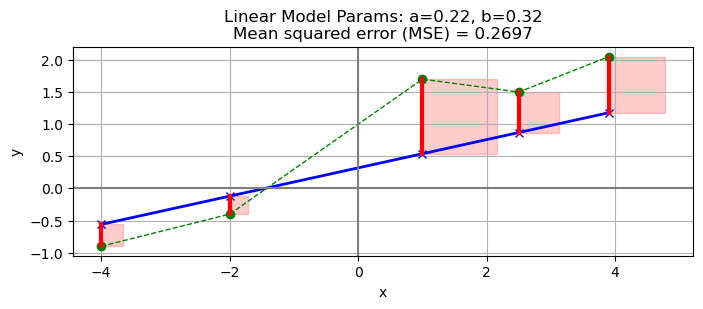

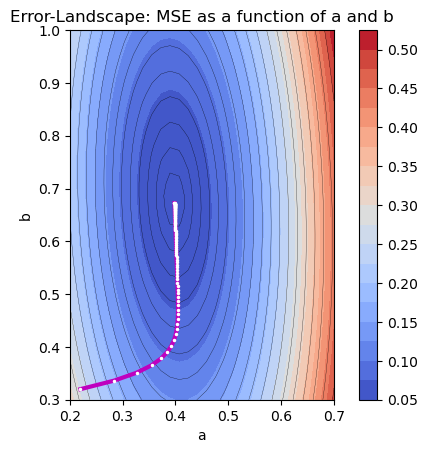

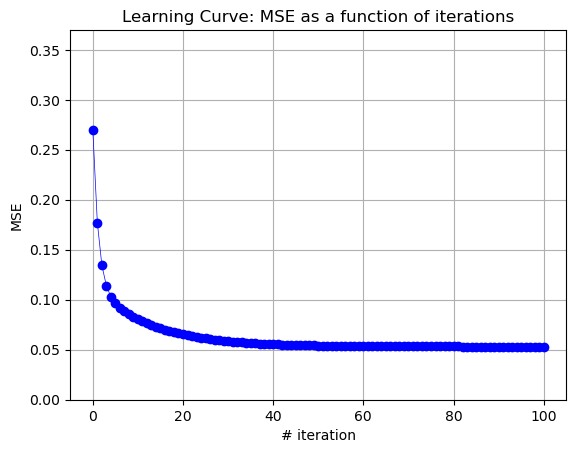

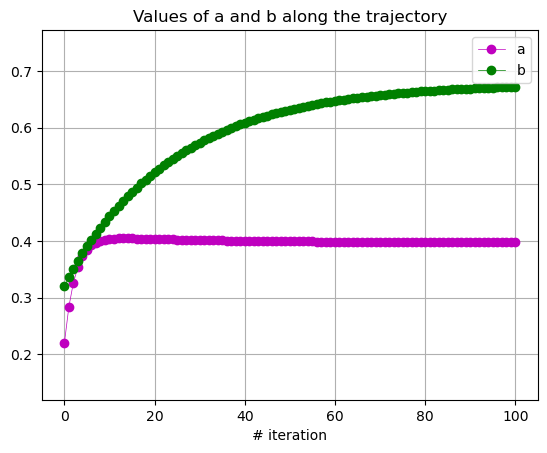

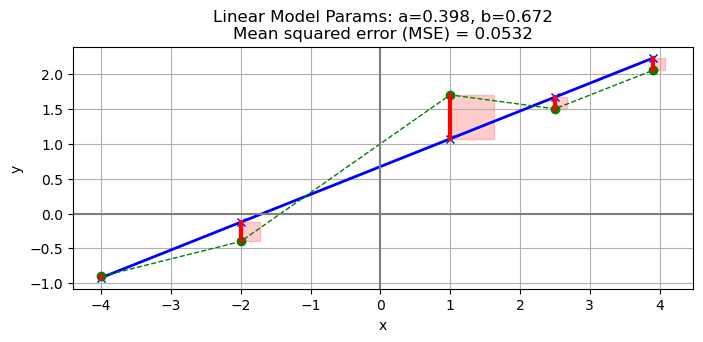

In [23]:

# set the learning rate alpha and the number of iterations
alpha = 0.04
n_iter = 100

# set the initial value [a,b]_t0:
a0 = 0.22
b0 = 0.32

# visualize the initial model
plt_linear_model(a0, b0, data_X, data_Y, True)

# call the algorithm and then use the return values to visualize the iterations.
a, b, A, B, E = grad_descent(a0, b0, data_X, data_Y, alpha, n_iter)
    
# visualize the progression of the gradient descent
fig, ax = plot_error()
ax.plot(A,B, '-m', linewidth =3)
ax.plot(A,B, '.w', markersize=3)

plt.figure()
plt.plot(E, '-ob',linewidth =0.5, markersize=6)
plt.ylim([0, np.max(E)+0.1])
plt.grid()
plt.xlabel('# iteration')
plt.ylabel('MSE')
plt.title('Learning Curve: MSE as a function of iterations')

plt.figure()
plt.plot(A, '-om',linewidth =0.5, label="a")
plt.plot(B, '-og',linewidth =0.5, label="b")
plt.ylim([np.min([A,B])-0.1, np.max([A,B])+0.1])
plt.grid()
plt.xlabel('# iteration')
plt.title('Values of a and b along the trajectory')
plt.legend()


plt_linear_model(a, b, data_X, data_Y, True)



## Problems
- Local Minima

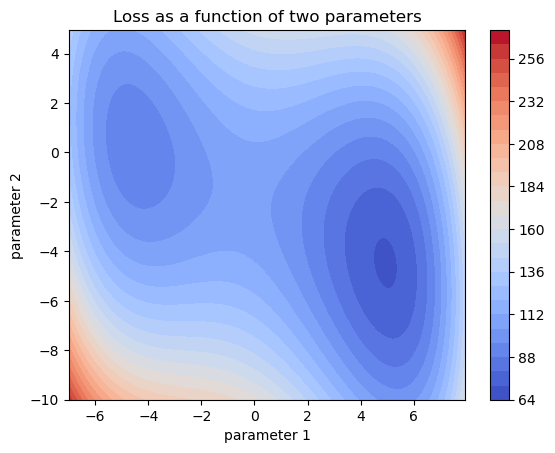

In [24]:
p1 = np.arange(-7, 8, 0.05)
p2 = np.arange(-10, 5, 0.05)
p1m, p2m = np.meshgrid(p1, p2, sparse=True)
z =  0.05*p1m**4 -2*p1m**2 + p1m*p2m + 4*p2m + p2m**2 + 110
h = plt.contourf(p1,p2,z, levels=30, cmap=cm.coolwarm)
plt.colorbar(h)
plt.xlabel('parameter 1')
plt.ylabel('parameter 2')
plt.title("Loss as a function of two parameters")
plt.show()

# Stochastic Gradient Descent (SGD)

In the example above, we were given $N=5$ data points. When evaluating the gradient of the loss function, we were taking into account all those five points. Imagine we were given $N=1'000$ points. Then, at each iteration, we would have to iterate over all $N=1'000$ points to calculate the gradient of the loss function. 

**The idea behind Stochastic Gradient Descent (SGD) is that we do not need the *exact* gradient to find a trajectory toward the minimum. Instead, at each iteration we can randomly pick a few datapoints and use them to calculate an *approximation* of the gradient.**

In the following equations, we use the symbol $J_n$ to denote a set of $n$ indices, randomly chosen from the interval [1 N].


$$
\begin{align}
\textrm{E} &= \frac{1}{2N} \sum_{i=1}^{N} (y_i - (a \cdot x_i + b))^2 \\
\frac{\partial \textrm{E}}{\partial a} &= \frac{1}{N} \sum_{i=1}^{N} (y_i - (a \cdot x_i + b)) (-x_i) \\
&\approx \frac{1}{n} \sum_{j \in J_n} (y_j - (a \cdot x_j + b)) (-x_j)  \\
\frac{\partial \textrm{E}}{\partial b} &= \frac{1}{N} \sum_{i=1}^{N} (y_i - (a \cdot x_i + b)) (-1) \\
&\approx \frac{1}{n} \sum_{j \in J_n} (y_{j} - (a \cdot x_{j} + b)) (-1)  \\
\end{align}
$$





We now visualize the error landscape for three different subsets (each of size $n=3$) of the given data. Note that we add the same point (a0, b0) to each of the three figures and show the respective gradients.





(0.41983333333333334,
 0.535,
 <Figure size 700x500 with 2 Axes>,
 <Axes: title={'center': 'Err_orig= 0.1034 | Err_new= 0.0962 \nChange= -0.007125'}, xlabel='a', ylabel='b'>)

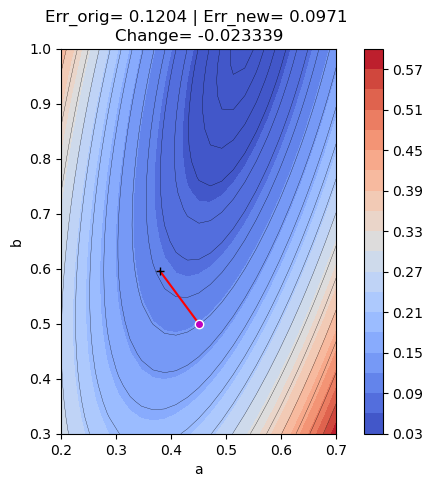

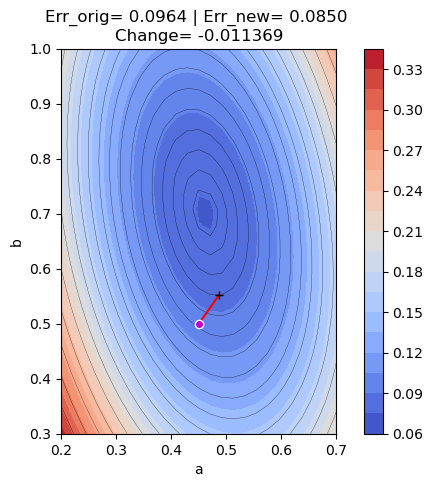

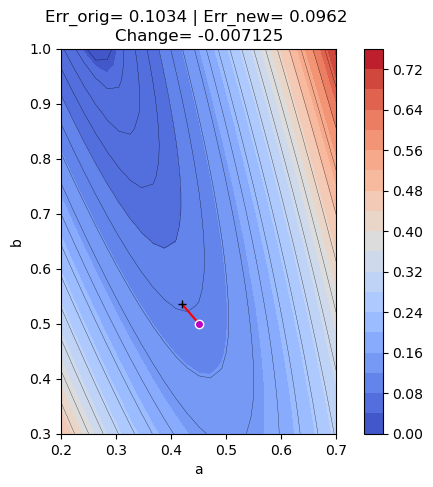

In [25]:
a0 = 0.45
b0 = 0.5

alpha = 0.25  # we chose a large value to emphasize the effect in the figures below

J = [0, 1, 2]
[da, db] = gradE(data_X[J], data_Y[J], a0, b0)
plot_error_and_grad(a0, -da, b0, -db, alpha, data_X[J], data_Y[J])

J = [1, 2, 3]
[da, db] = gradE(data_X[J], data_Y[J], a0, b0)
plot_error_and_grad(a0, -da, b0, -db, alpha, data_X[J], data_Y[J])

J = [2, 3, 4]
[da, db] = gradE(data_X[J], data_Y[J], a0, b0)
plot_error_and_grad(a0, -da, b0, -db, alpha, data_X[J], data_Y[J])



# Batch-size

The number $n$ (nr of samples, used to approximate the gradient) is called **batch size**. For the case of $n=1$ we get the following equations. 

$$
\begin{align}
\textrm{E} &= \frac{1}{2N} \sum_{i=1}^{N} (y_i - (a \cdot x_i + b))^2 \\[20pt]
\frac{\partial \textrm{E}}{\partial a} &= \frac{1}{N} \sum_{i=1}^{N} (y_i - (a \cdot x_i + b)) (-x_i) \\
&\approx \frac{1}{n} \sum_{j \in J_n} (y_j - (a \cdot x_j + b)) (-x_j)  \\
\frac{\partial E_j}{\partial a} &= (y_j - (a \cdot x_j + b)) (-x_j) \\[20pt] 
\frac{\partial \textrm{E}}{\partial b} &= \frac{1}{N} \sum_{i=1}^{N} (y_i - (a \cdot x_i + b)) (-1) \\
&\approx \frac{1}{n} \sum_{j \in J_n} (y_{j} - (a \cdot x_{j} + b)) (-1)  \\
\frac{\partial E_j}{\partial b} &= (y_{j} - (a \cdot x_{j} + b)) (-1)
\end{align}
$$




Approximating the gradient based on a **single** sample only is not accurate at all (look at the previous figures). But we can compensate for that: By reducing the step-size (learning rate), the effect of each single error will be reduced. On average, over many steps, the algorithm still moves toward the minimum.




## The SGD Algorithm:

Stochastic Gradient Descent implements the following update rule:

$$
\begin{align}
   \begin{bmatrix}
           a \\
           b \\
         \end{bmatrix}_{t+1} 
         =    \begin{bmatrix}
           a \\
           b \\
         \end{bmatrix}_{t} - \alpha 
         \begin{bmatrix}
           \frac{\partial E_j}{\partial a} \\
           \frac{\partial E_j}{\partial b} \\
         \end{bmatrix} \Big\rvert _{\begin{bmatrix}
           a \\
           b \\
         \end{bmatrix}_{t} }
  \end{align}
  \\
$$

Unlike Gradient Descent, SGD does not use the true gradient but an approximation using a **single** datum ($n=1$). Note that at each iteration a new random sample (here denoted by j) is drawn from the dataset. Over many iterations, all data contribute to the calculation.

A common variant of SGD is using so called **mini-batches** ($1<n<N$). Increasing the batch-size will reduce the variance of the gradient estimation. That is, there's a compromise between the smallest batch-size $n=1$ (which yields a very noisy gradient) and the largest batch-size $n=N$ (which is expensive to calculate). There's no "best" batch-size, but often mini-batches of size $n=32$ or $n=64$ are used. 

In the implementation below we provide a batch size parameter and you should vary it to observe the effect.

In [28]:
# Implements the stochastic gradient descent method
# Returns the final values of a and b and intermediate results (useful for visualization).
def stochastic_grad_descent(a0, b0, X, Y, scaling, n, nr_iter):
    # we now need a random number generator to pick n random indices
    rand_gen = np.random.default_rng()
    N = len(X)
    a = a0
    b = b0
    A = np.zeros(nr_iter+1)
    B = np.zeros(nr_iter+1)
    E = np.zeros(nr_iter+1)
    A[0] = a
    B[0] = b
    E[0] = sq_err(X, Y, a, b) # For visualization only.
    for i in range(nr_iter):
        # at each iteration, sample n points:
        J = rand_gen.choice(N, size=n, replace=False)
        Xn = X[J] #data_X[J]
        Yn = Y[J] #Data_Y[J]
        [da, db] = gradE(Xn, Yn, a, b)
        a -= scaling * da
        b -= scaling * db
        A[i+1] = a
        B[i+1] = b
        E[i+1] = sq_err(X, Y, a, b) # For visualization only.

    return a, b, A, B, E

(0.4221574575344049, 0.744493486292164)

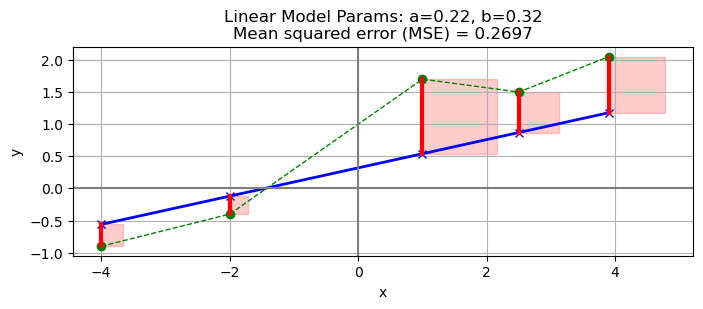

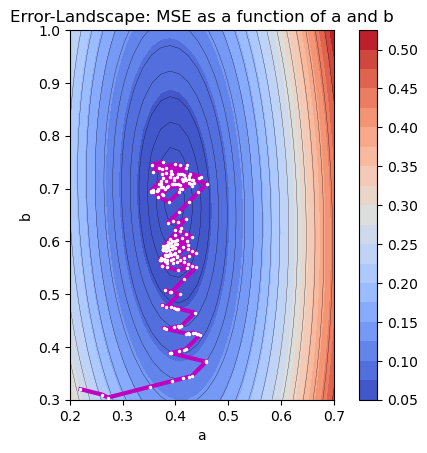

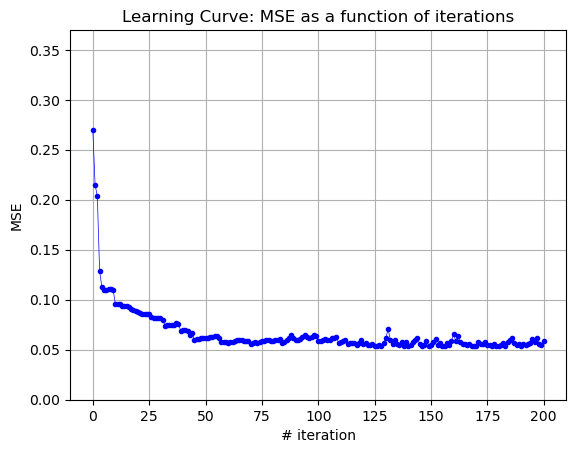

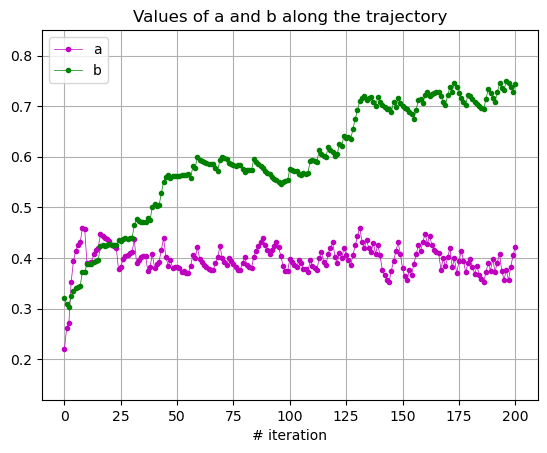

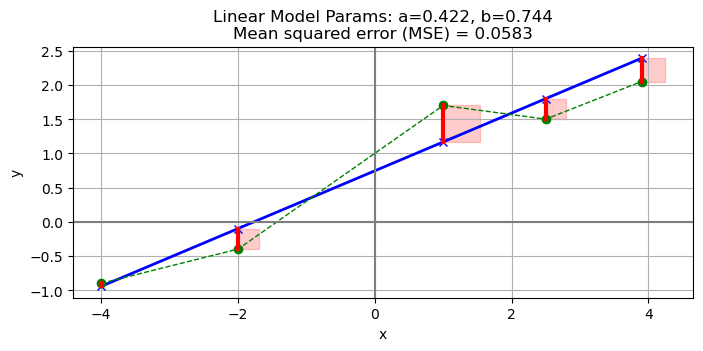

In [29]:

# set the learning rate alpha and the number of iterations
alpha = 0.03
n_iter = 200

# set the number of samples used to approximate the gradient (aka batch size)
batch_size = 1

# set the initial value [a,b]_t0:
a0 = 0.22
b0 = 0.32
# a0 = 0.4
# b0 = 0.7

# visualize the initial model:
plt_linear_model(a0, b0, data_X, data_Y, True)

# call the algorithm and then use the return values to visualize the iterations.
a, b, A, B, E = stochastic_grad_descent(a0, b0, data_X, data_Y, alpha, batch_size, n_iter)
    
# visualize the progression of the gradient descent
fig, ax = plot_error()
ax.plot(A,B, '-m', linewidth =3)
ax.plot(A,B, '.w', markersize=3)

plt.figure()
plt.plot(E, '-ob',linewidth =0.5, markersize=3)
plt.ylim([0, np.max(E)+0.1])
plt.grid()
plt.xlabel('# iteration')
plt.ylabel('MSE')
plt.title('Learning Curve: MSE as a function of iterations')

plt.figure()
plt.plot(A, '-om',linewidth =0.5, label="a", markersize=3)
plt.plot(B, '-og',linewidth =0.5, label="b", markersize=3)
plt.ylim([np.min([A,B])-0.1, np.max([A,B])+0.1])
plt.grid()
plt.xlabel('# iteration')
plt.title('Values of a and b along the trajectory')
plt.legend()


plt_linear_model(a, b, data_X, data_Y, True)




## Stochastic Gradient Descent with annealed learning rate

We have seen that, for a fixed learning rate $\alpha$, SGD does not converge. Instead, the algorithm keeps fluctuating around the minimum. One can set $\alpha$ to a very small value, in which case the fluctuations are smaller and SGD stays 'close enough' to the minimum during the 'late iterations'. Therefore, in order to obtain a result of high accuracy, one would choose a very **small** $\alpha$.


During the 'early iterations', the situation is different: There is no benefit staying close to the optimal trajectory (compare with exercise above, where you set $\alpha=0.0001$). As long as SGD moves roughly in the direction toward the minimum, fluctuations (even relatively large ones) around the 'optimal' trajectory are acceptable. One would therefore choose a **large** $\alpha$ in order to improve the speed of the algorithm.


**Annealing solves this appearent contradiction by adapting the learning rate. It starts with a large $\alpha$ and reduces it over time.** There are many options (so called schedules) how one can reduce the learning rate over time. Here we decay the learning rate by multiplying it at each iteration by a decay_factor.



In [31]:
# Implements the stochastic gradient descent method with annealing
# Returns the final values of a and b and intermediate results (useful for visualization).
def annealed_stochastic_grad_descent(a0, b0, X, Y, scaling, n, nr_iter, annealing_factor = 0.99, lower_bound = 1e-4):
    # we now need a random number generator to pick n random indices
    rand_gen = np.random.default_rng()
    N = len(X)
    a = a0
    b = b0
    A = np.zeros(nr_iter+1)
    B = np.zeros(nr_iter+1)
    E = np.zeros(nr_iter+1)
    S = np.zeros(nr_iter+1)
    A[0] = a
    B[0] = b
    E[0] = sq_err(X, Y, a, b) # For visualization only.
    S[0] = scaling
    for i in range(nr_iter):
        # at each iteration, sample n points:
        J = rand_gen.choice(N, size=n, replace=False)
        Xn = X[J]
        Yn = Y[J]
        [da, db] = gradE(Xn, Yn, a, b)
        a -= scaling * da
        b -= scaling * db
        scaling = np.max([scaling*annealing_factor, lower_bound])
        A[i+1] = a
        B[i+1] = b
        E[i+1] = sq_err(X, Y, a, b) # For visualization only.
        S[i+1] = scaling

    return a, b, A, B, E, S

(0.40431346865241113, 0.7123600405794901)

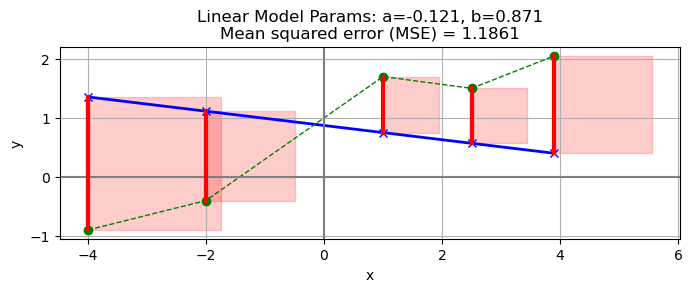

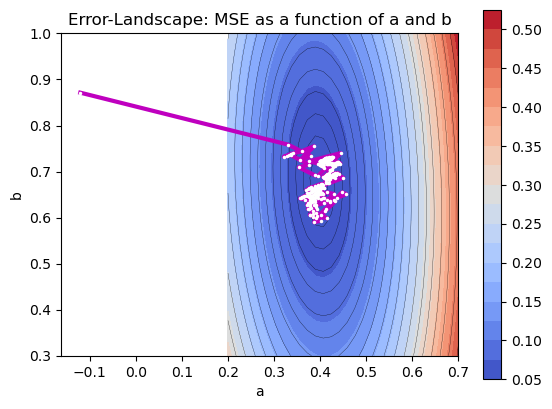

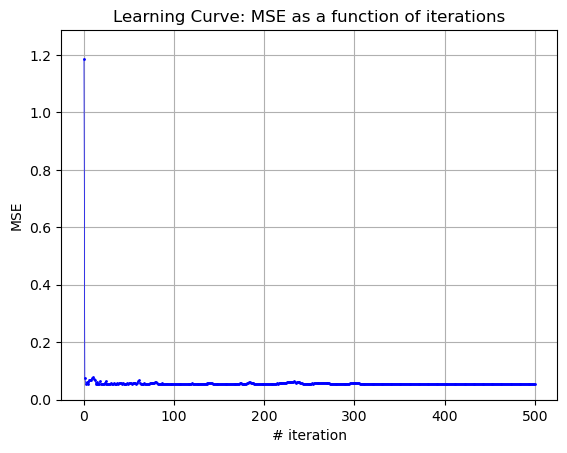

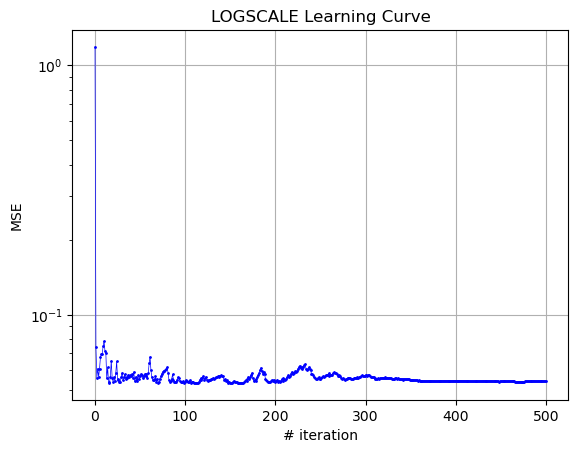

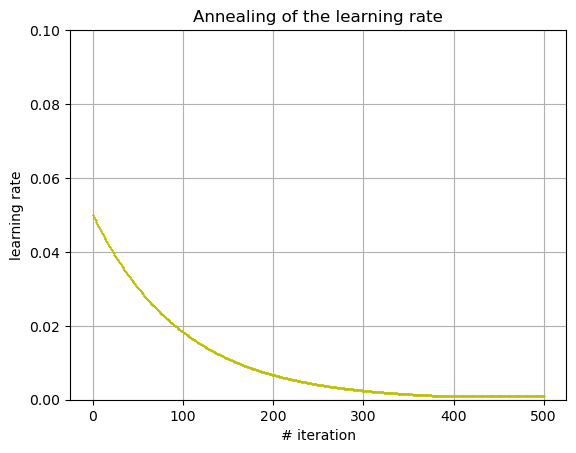

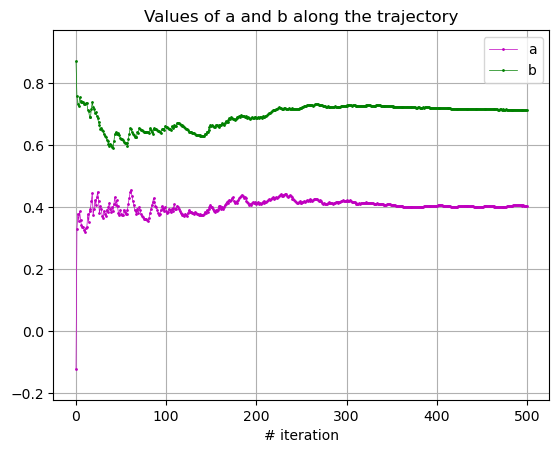

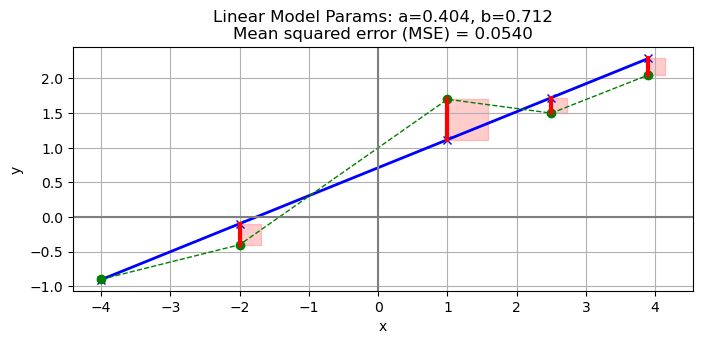

In [32]:

# set the learning rate alpha and the number of iterations
alpha = 0.05
n_iter = 500

# set the number of samples used to approximate the gradient (aka batch size)
batch_size = 1

# set the initial value [a,b]_t0:
a0 = 0.25
b0 = 0.35

# Alternatively, use a random initial value: create random number generator. 
rng = np.random.default_rng()
a0 = rng.uniform(-0.2,0.7)
b0 = rng.uniform(0.3,1.0)



# parameters of the learning rate annealing
annealing_factor = 0.99
lower_bound = 1e-3

# visualize the initial model:
plt_linear_model(a0, b0, data_X, data_Y, True)

# call the algorithm and then use the return values to visualize the iterations.
a, b, A, B, E, S = annealed_stochastic_grad_descent(a0, b0, data_X, data_Y, 
                                                    alpha, batch_size, n_iter, 
                                                    annealing_factor, lower_bound)
    
# visualize the progression of the gradient descent
fig, ax = plot_error()
ax.plot(A,B, '-m', linewidth =3)
ax.plot(A,B, '.w', markersize=3)

plt.figure()
plt.plot(E, '-ob',linewidth =0.5, markersize=1)
plt.ylim([0, np.max(E)+0.1])
plt.grid()
plt.xlabel('# iteration')
plt.ylabel('MSE')
plt.title('Learning Curve: MSE as a function of iterations')


plt.figure()
plt.plot(E, '-ob',linewidth =0.5, markersize=1)
# plt.ylim([0, np.max(E)+0.1])
plt.grid()
plt.xlabel('# iteration')
plt.ylabel('MSE')
plt.yscale('log')
plt.title('LOGSCALE Learning Curve')


plt.figure()
plt.plot(S, '-xy',linewidth =0.5, markersize=1)
plt.ylim([0, np.max(S)+0.05])
plt.grid()
plt.xlabel('# iteration')
plt.ylabel('learning rate')
plt.title('Annealing of the learning rate')

plt.figure()
plt.plot(A, '-om',linewidth =0.5, label="a", markersize=1)
plt.plot(B, '-og',linewidth =0.5, label="b", markersize=1)
plt.ylim([np.min([A,B])-0.1, np.max([A,B])+0.1])
plt.grid()
plt.xlabel('# iteration')
plt.title('Values of a and b along the trajectory')
plt.legend()


# visualize the final model:
plt_linear_model(a, b, data_X, data_Y, True)




Appendix  
Typical mistakes:  
* take the derivative w.r.t. x instead of the parameters a, b, ...  
* chain-rule! don't forget the "inner derivative"


$\frac{\partial E}{\partial a} = \frac{1}{N}\sum_{i=1}^N (y_i - (a \cdot x_i + b)) \cdot -x_i$  

$\frac{\partial E}{\partial b} = \frac{1}{N}\sum_{i=1}^N (y_i - (a \cdot x_i + b)) \cdot -1$

$$
\begin{align}
    \textrm{Gradient of E} = \begin{bmatrix}
           \frac{\partial E}{\partial a} \\
           \frac{\partial E}{\partial b} \\
         \end{bmatrix}
         =\begin{bmatrix}
           \frac{1}{N}\sum_{i=1}^N (y_i - (a \cdot x_i + b))(-x_i) \\
           \frac{1}{N}\sum_{i=1}^N (y_i - (a \cdot x_i + b))(-1) \\
         \end{bmatrix}
  \end{align}
$$
